# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
# Importaciones de librerías estándar
import logging
import math
import re

# Importaciones de librerías científicas y matemáticas
import numpy as np
import pandas as pd

# Importaciones de visualización
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

# Importaciones de procesamiento de lenguaje natural (NLP)
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.model_selection import train_test_split

# Importaciones de aprendizaje automático (Machine Learning)
import sklearn.metrics as metrics
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

# Importaciones de aprendizaje profundo (Deep Learning)
import torch
import transformers
from torch.utils.data import DataLoader, Dataset, TensorDataset
from transformers import (AdamW, BertConfig, BertForSequenceClassification, 
                          BertModel, BertTokenizer)

# Importaciones para seguimiento del progreso
from tqdm import tqdm
from tqdm.auto import tqdm

# Importaciones para paralelización
from joblib import Parallel, delayed

In [2]:
# Código preecargado
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# Código preecargado, esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
# Dataset sobre reseñas en Imdb, separado por tabuladores
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
# Elegir una muestra de 5 filas aleatorias
df_reviews.sample(5)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
37685,tt0406816,movie,The Guardian,The Guardian,2006,\N,139,0,"Action,Adventure,Drama",6.9,85875,My yardstick for measuring a movie's watch-abi...,7,pos,1,test,2
44725,tt0180274,movie,Unhinged,Unhinged,1982,\N,79,0,Horror,5.1,1528,I had never heard of this one before the owner...,2,neg,0,train,9435
29783,tt0108915,tvMiniSeries,Scarlett,Scarlett,1994,1994,360,0,"Drama,Romance",6.5,2762,"A letter to the guys. I tried guys, I really t...",10,pos,1,test,8407
6591,tt0092067,movie,Castle in the Sky,Tenkû no shiro Rapyuta,1986,\N,125,0,"Adventure,Animation,Drama",8.0,143316,Castle in the sky is undoubtedly a Hayao Miyaz...,8,pos,1,train,4063
8379,tt0039286,movie,Crossfire,Crossfire,1947,\N,86,0,"Crime,Drama,Film-Noir",7.3,7018,**** SPOILERS THROUGHOUT **** This is a very s...,9,pos,1,test,9371


In [6]:
# Exploración inicial del dataset df_reviews
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [7]:
# Conservar solo las columnas relevantes para el entrenamiento del modelo
columns_to_keep = ['tconst', 'review', 'rating', 'sp', 'pos', 'ds_part', 'genres',  'start_year']
df_reviews = df_reviews[columns_to_keep]

# Verificar las columnas restantes
print(df_reviews.columns)

Index(['tconst', 'review', 'rating', 'sp', 'pos', 'ds_part', 'genres',
       'start_year'],
      dtype='object')


In [8]:
# Búsqueda de valores nulos y repetidos en el dataset

# Buscar valores nulos
null_values = df_reviews.isnull().sum()
print("Valores nulos por columna:\n", null_values)

# Buscar filas duplicadas
duplicated_rows = df_reviews.duplicated().sum()
print("Número de filas duplicadas:", duplicated_rows)


Valores nulos por columna:
 tconst        0
review        0
rating        0
sp            0
pos           0
ds_part       0
genres        0
start_year    0
dtype: int64
Número de filas duplicadas: 85


In [9]:
# Eliminar filas duplicadas
df_reviews = df_reviews.drop_duplicates()

# Verificar que no haya filas duplicadas
duplicated_rows = df_reviews.duplicated().sum()
print("Número de filas duplicadas después de la eliminación:", duplicated_rows)


Número de filas duplicadas después de la eliminación: 0


In [10]:
# Obtener una revisión estadística rápida de las columnas numéricas del dataset
df_reviews.describe()

,rating,pos,start_year
count,47246.000000,47246.000000,47246.000000
mean,5.482835,0.498751,1989.625873
std,3.472662,0.500004,19.607462
min,1.000000,0.000000,1894.000000
25%,2.000000,0.000000,1982.000000
50%,4.000000,0.000000,1998.000000
75%,9.000000,1.000000,2004.000000
max,10.000000,1.000000,2010.000000


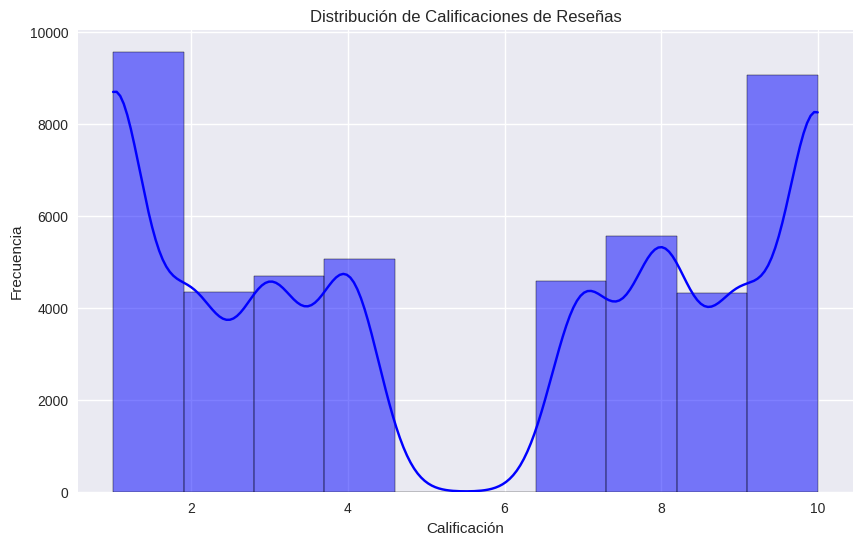

In [11]:
# Distribución de las calificaciones de las reseñas
plt.figure(figsize=(10, 6))
sns.histplot(df_reviews['rating'], bins=10, kde=True, color='blue')
plt.title('Distribución de Calificaciones de Reseñas')
plt.xlabel('Calificación')
plt.ylabel('Frecuencia')
plt.show()

La distribución de las calificaciones de las reseñas (rating) tiene una media de aproximadamente 5.48, lo que indica que en promedio las reseñas tienden a ser moderadas.   
La desviación estándar es de 3.47, sugiriendo una amplia variabilidad en las calificaciones. La mediana es 4, lo que significa que la mitad de las reseñas tienen una calificación de 4 o menor.

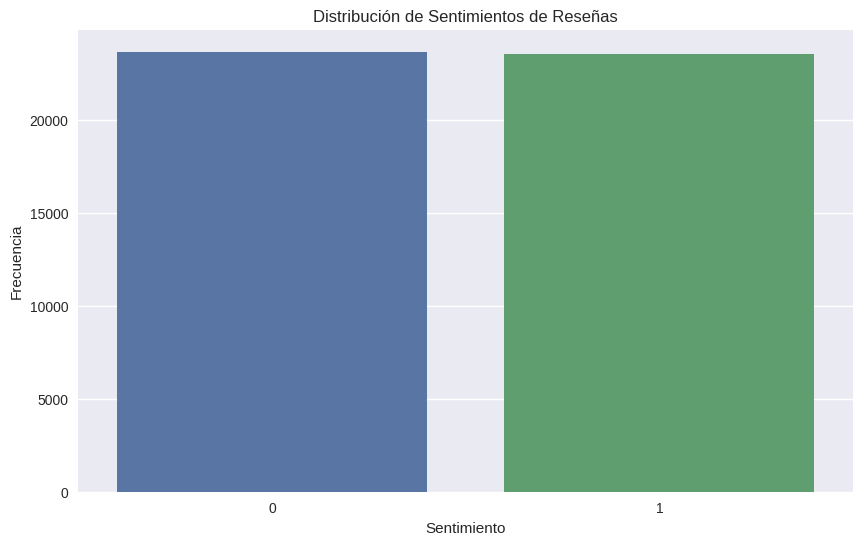

In [12]:
# Distribución de los sentimientos de las reseñas
plt.figure(figsize=(10, 6))
sns.countplot(x='pos', data=df_reviews)
plt.title('Distribución de Sentimientos de Reseñas')
plt.xlabel('Sentimiento')
plt.ylabel('Frecuencia')
plt.show()


En el sentimiento de las reseñas (pos), hay un equilibrio casi perfecto entre las reseñas positivas (etiquetadas como '1') y negativas (etiquetadas como '0'), con una media cercana a 0.50 y una desviación estándar mínima, lo que indica un balance casi uniforme en el conjunto de datos.

**Observaciones de la salida después de usar describe():**

Estas observaciones sugieren que el conjunto de datos está equilibrado en términos de sentimientos y tiene una variabilidad considerable en las calificaciones de las reseñas.

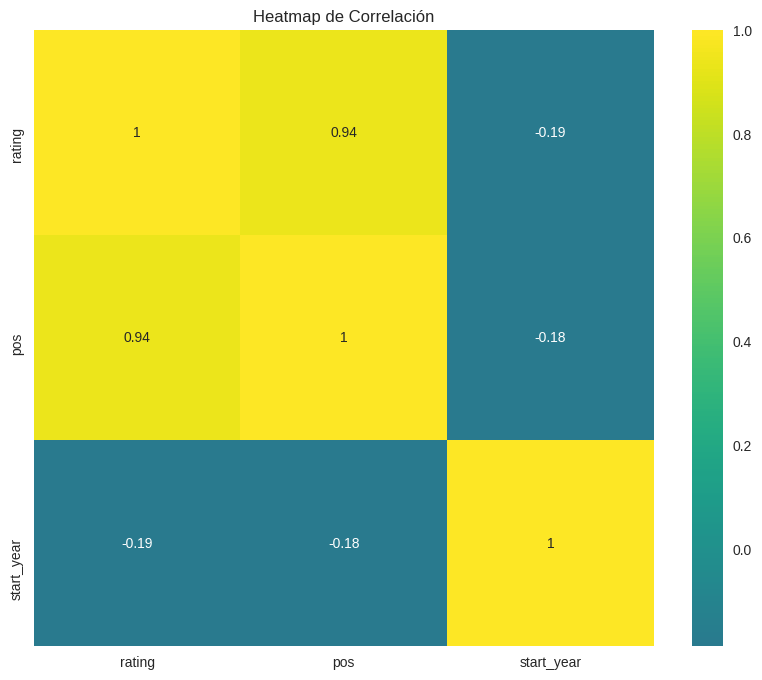

In [13]:
# Buscar correlación entre reseñas y sentimientos de la reseñas con un heatmap

# Calcular la matriz de correlación
correlation_matrix = df_reviews.corr()

# Crear un heatmap de la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', center=0)
plt.title('Heatmap de Correlación')
plt.show()


**Observaciones de al salida del heatmap**

El heatmap muestra una alta correlación (0.94) entre las calificaciones (rating) y el sentimiento positivo (pos). Lo que indica una fuerte relación entre ambos, donde las calificaciones altas tienden a corresponder con sentimientos positivos.

### Conclusión de preprocesamiento de datos

- Se verificó usando el método info() que los tipos de datos en las columnas fueran adecuados para su psoterior manejo
- Se eliminaron las columnas irrelevantes para el entrenamiento del modelo, manteniendo las oclumnas 'tconst', 'review', 'rating', 'sp', 'pos', 'ds_part', 'genres',  'start_year'
- Se verificó la existencia de valores nulos y duplicados, se elimaron 85 filas duplicadas del dataset, por no tener un efecto significativo con el conjunto de datos y para optimizar el aprendizaje del modelo
- Se hizo una revisión de métricas estadísticas de las columnas numéricas usando el método describe()
- Se analizó la distribución de las métricas clave 'rating' y 'pos'
- Se agregó un heatmap de correlación entre las columnas 'rating' y 'pos' que msotró una fuerte relación entre ambas. Evidenciando una dependencia fuerte entre las calificaciones de los usuarios y sentimeinto de las reseñas. (Las calificaciones altas tienden a corresponder con sentimientos positivos).